# Cours M2 EDP et modélisation: simulations numériques de l'équation des ondes

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.optimize
import math 
from math import sin, pi, exp
import os
%matplotlib notebook
from matplotlib.animation import FuncAnimation

Le but est de résoudre par une méthode de différences finies l'équation des ondes
$$
\partial_{tt} u(t,x) - \partial_{xx} u(t,x) = 0 \qquad \text{sur $(0,1)$}
$$
avec des conditions de bord périodiques ($u(t,0) = u(t,1)$) et une condition initiale $u(0,x) = u_i(x)$ et $\partial_t u(0,x) = v_i(x)$.

Soit $X \in \mathbb{N}^*$. On note $\displaystyle \Delta x := \frac{1}{X}$ et pour tout $i \in \mathbb{Z}$, on notera $x_i = i \Delta x$ de telle sorte que $x_0 = 0 < x_1 < \cdots < x_X = 1$. 

In [2]:
X = 100 # Nombre de points de discretisation
xx = np.linspace(0, 1, X+1)
dx = 1.0/X
print("les deux valeurs extremales de xx sont ",xx[0]," et ",xx[X])

les deux valeurs extremales de xx sont  0.0  et  1.0


In [3]:
#On definit le pas de temps et le nombre de pas de temps
#dt = 0.05 # 0.05 0.09 0.11 pour X=10
dt = 0.005 # 0.005 0.009 0.011 pour X=100
#M = 40 # pour X=10
M = 400 # pour X=100
instant = np.zeros(M)
for ii in range(0,M):
    instant[ii] = ii*dt

# On definit la condition initiale (periodique!)
U0full = np.zeros(X+1)
V0full = np.zeros(X+1)
regul = True # True pour CI reguliere, False sinon
#regul = False
if regul:
    # CI reguliere
    for i in range(0,X+1):
        #U0full[i] = sin(2*pi*xx[i]) # mode propre operateur, à eviter
        pic = int(X/2)
        U0full[i] = exp(-80*(xx[i]-xx[pic])**2) 
        V0full[i] = 0
else:
    # CI irreguliere (pour cette CI, symplectic Euler, LF et FW se sont pas parfaits)
    # On voit bien les aspects dissipatifs de LF
    pic = int(2*X/5)
    picc = int(3*X/5)
    for i in range(pic,picc):
        U0full[i] = 1.
        V0full[i] = 0.
print("les deux valeurs extremales de U0full sont ",U0full[0]," et ",U0full[X])

# On prend la restriction en eliminant le dernier ddl (car CL periodiques)
U0 = np.zeros(X)
V0 = np.zeros(X)
for i in range(0,X):
    U0[i] = U0full[i]
    V0[i] = V0full[i]
print("les deux valeurs extremales de U0 sont ",U0[0]," et ",U0[X-1])

# On evalue la valeur de la condtion CFL $\Delta t / \Delta x$ 
# quantité pertinente pour le schéma decentré amont, LF, LW: elle doit etre inferieure à 1
CFL = dt/dx
print("CFL = ", CFL)

les deux valeurs extremales de U0full sont  2.061153622438558e-09  et  2.061153622438558e-09
les deux valeurs extremales de U0 sont  2.061153622438558e-09  et  4.55063069183236e-09
CFL =  0.5


<IPython.core.display.Javascript object>


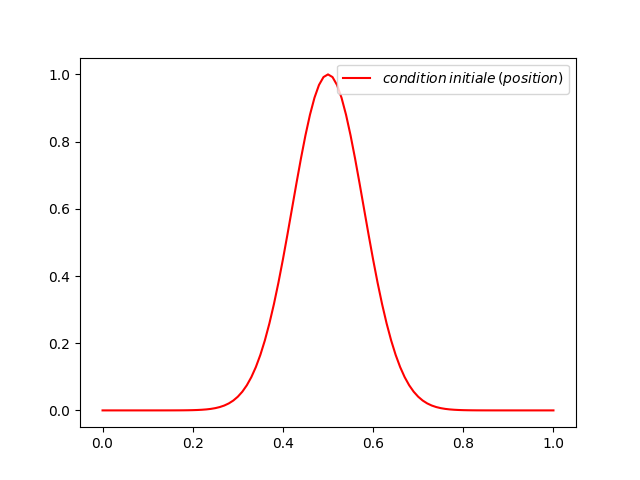

In [4]:
# On visualise la condition initiale en position
plt.plot(xx,U0full, 'r', label ="$condition \, initiale \, (position)$")
plt.legend()
plt.show()

In [5]:
plt.close()

In [6]:
# Definition de matrices utiles

# matrice identite
Idd = np.eye(X) 

# matrice sur-diagonale
MatU = np.zeros((X,X))
for i in range(0,X-1):
   MatU[i,i+1] = 1
MatU[X-1,0] = 1 

# matrice sous-diagonale
MatD = np.zeros((X,X))
for i in range(1,X):
   MatD[i,i-1] = 1
MatD[0,X-1] = 1 

# 1- Schéma symplectic Euler

In [7]:
# On discretise le laplacien par une formule centrée, ce qui donne un pb hamiltonien en temps
# On discretise en temps ce pb hamiltonien par symplectic Euler
# Definition de la matrice de passage

D = np.zeros((X,X))
D = (dt/(dx*dx))*(MatU+MatD-2*Idd)

In [8]:
# visualisation de la matrice de passage
print(D)

[[-100.   50.    0. ...    0.    0.   50.]
 [  50. -100.   50. ...    0.    0.    0.]
 [   0.   50. -100. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... -100.   50.    0.]
 [   0.    0.    0. ...   50. -100.   50.]
 [  50.    0.    0. ...    0.   50. -100.]]


In [9]:
# On realise l'iteration en temps 
     
# On va stocker dans Utab et Vtab la solution aux differents pas de temps
Utab = np.zeros((X,M))
U = U0
Vtab = np.zeros((X,M))
V = V0

for ii in range(0,M):
    Utab[:,ii] = U
    Vtab[:,ii] = V
    Unew = U + dt*V # explicite en position
    Vnew = V + np.dot(D,Unew) ## implicite en vitesse
    U = Unew
    V = Vnew
    
# On complete les tableaux pour avoir le dernier point
Ufull = np.zeros((X+1,M))
Vfull = np.zeros((X+1,M))
for ii in range(0,M):
    for jj in range(0,X):
        Ufull[jj,ii] = Utab[jj,ii]
        Vfull[jj,ii] = Vtab[jj,ii]
    Ufull[X,ii] = Utab[0,ii]    
    Vfull[X,ii] = Vtab[0,ii]

Le but des lignes de code ci-dessous est d'afficher l'évolution de la fonction $u(t,x)$

<IPython.core.display.Javascript object>


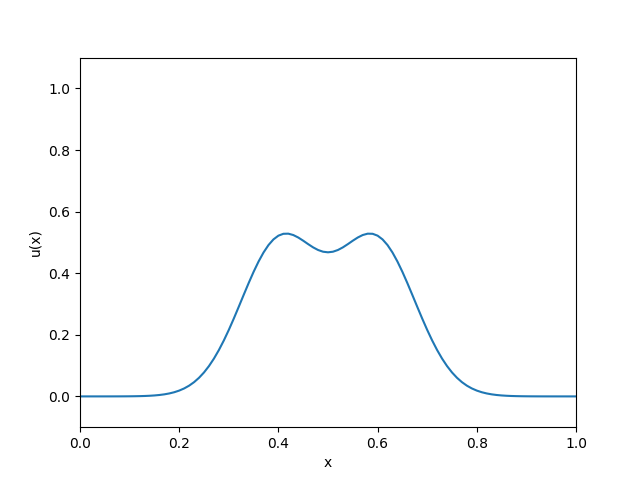

In [10]:
## Le but de cette fonction est d'afficher l'évolution de u(t,x) au cours du temps
fig1, ax1 = plt.subplots(1)
plotU,  = ax1.plot(xx,Ufull[:,0])

def animate(p):
    UU = Ufull[:,p]
    plotU.set_ydata(UU) 
    
def init(): 
    ax1.set_xlim(0, 1)
    ax1.set_ylim( -0.1, 1.1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('u(x)')    
    return plotU,

step = 1
steps = np.arange(1,M,step)
ani1 = FuncAnimation(fig1, animate,steps, init_func = init, interval = 500, blit = True)

In [11]:
plt.close()

In [12]:
# valeur maximale de la position au cours du temps
Umax = np.zeros(M)
for ii in range(0,M):
    Umax[ii] = max(Ufull[:,ii])

<IPython.core.display.Javascript object>


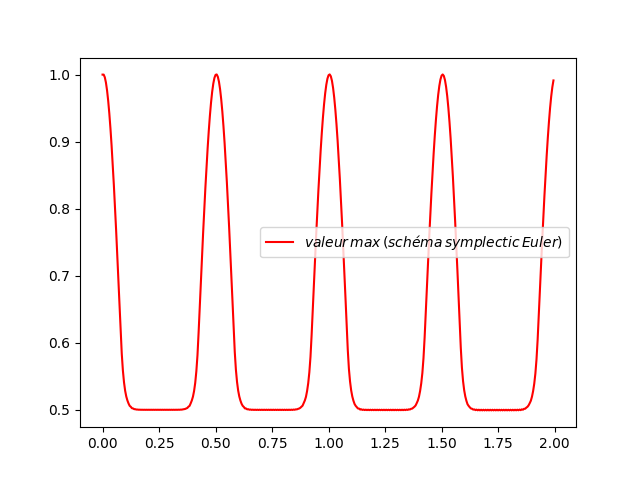

In [13]:
# On visualise la valeur max au cours du temps
plt.plot(instant,Umax, 'r', label ="$valeur \, max \, (schéma \, symplectic \, Euler)$")
plt.legend()
plt.show()

In [14]:
plt.close()

In [15]:
# energie au cours du temps (v represente d_t u)
Energie = np.zeros(M)
for nn in range(0,M):
    for ii in range(0,X):
        incre = (Vfull[ii,nn])**2 + ((Ufull[ii+1,nn]-Ufull[ii,nn])/dx)**2
        Energie[nn] = Energie[nn] + dx*incre/2
    incre = (Vfull[X,nn])**2 + ((Ufull[1,nn]-Ufull[X,nn])/dx)**2
    Energie[nn] = Energie[nn] + dx*incre/2

<IPython.core.display.Javascript object>


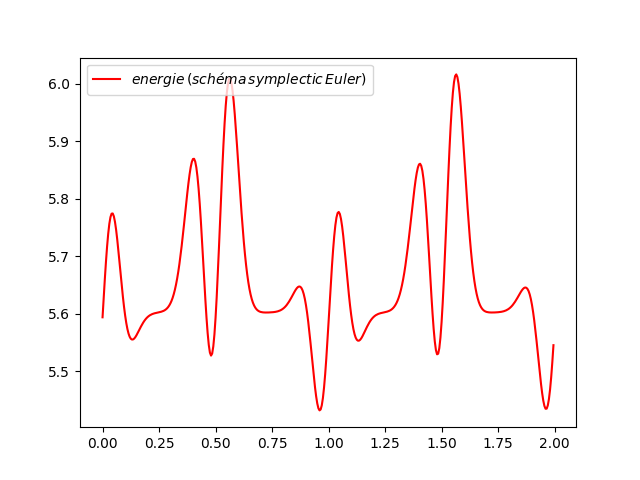

In [16]:
# On visualise la valeur de l'energie au cours du temps
plt.plot(instant,Energie, 'r', label ="$energie \, (schéma \, symplectic \, Euler)$")
plt.legend()
plt.show()

In [17]:
plt.close()